In [1]:
import torch
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version = 1)
X, Y = mnist['data'], mnist['target']

X_train, X_test, y_train, y_test = X[:60000]/255., X[60000:]/255. , Y[:60000].astype(np.int8), Y[60000:].astype(np.int8)
del X, Y

In [3]:
X_tr = torch.from_numpy(np.array(X_train)).float().cuda()
y_tr = torch.from_numpy(np.array(y_train)).long().cuda()

In [8]:
d_in = 784      # dimensión de datos de entrada
h = 150         # cantidad de nodos de la capa oculta
d_out = 10      # dimensión del espacio de predicción

epochs = 150        # épocas de entrenamiento
lr = 0.8            # learning rate
le = 10             # frecuencia de épocas para mostrar el progreso de entrenamiento

# instanciamos la arquitectrura de la red neuronal mediante la librería nn(neural networks)
model = torch.nn.Sequential(        
    torch.nn.Linear(d_in, h),
    torch.nn.ReLU(),
    torch.nn.Linear(h, d_out)
)
# creamos el modelo en la gpu
model.to('cuda')

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

l = []
# "preparar" el modelo para entrenar
model.train()
for e in range(1, epochs+1):

    # paso hacia delante
    y_pred = model(X_tr)

    # actualizar la pérdida
    loss = criterion(y_pred, y_tr)
    l.append(loss.item())

    # reiniciamos los gradientes para evitar la acumulación
    optimizer.zero_grad()

    # aplicamos la retropropagación
    loss.backward()

    # actualizamos los pesos en base a la función de pérdida
    optimizer.step()

    if not e % le:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

Epoch 10/150 Loss 1.73685
Epoch 20/150 Loss 1.55817
Epoch 30/150 Loss 1.27534
Epoch 40/150 Loss 1.09543
Epoch 50/150 Loss 0.95043
Epoch 60/150 Loss 0.85780
Epoch 70/150 Loss 0.77912
Epoch 80/150 Loss 0.71740
Epoch 90/150 Loss 0.66773
Epoch 100/150 Loss 0.62675
Epoch 110/150 Loss 0.59224
Epoch 120/150 Loss 0.56271
Epoch 130/150 Loss 0.53708
Epoch 140/150 Loss 0.51456
Epoch 150/150 Loss 0.49452


In [9]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis = -1, keepdims = True)
    
def evaluate(x):
    #"preparar" el modelo para generar predicciones
    model.eval()

    y_pred = model(x)
    y_prob = softmax(y_pred)
    return torch.argmax(y_prob, axis = 1)

from sklearn.metrics import accuracy_score
y_pred = evaluate(torch.from_numpy(np.array(X_test)).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9425

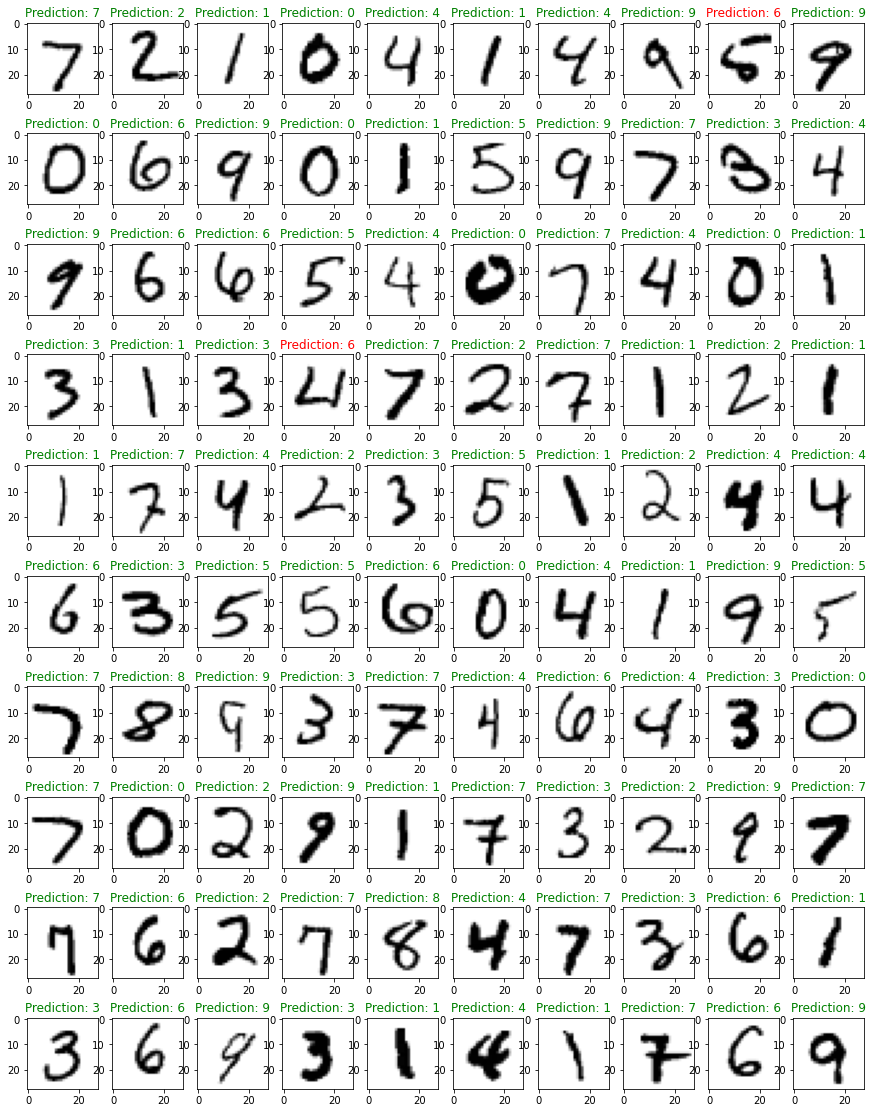

In [10]:
n_row = 10
n_col = 10

fig, axes = plt.subplots(n_row, n_col, figsize = (1.5*n_col, 2*n_row))

for i in range(n_row * n_col):
    image = X_test.iloc[i].values

    ax = axes[i//n_col, i % n_col]
    ax.imshow(np.reshape(image, (28,28)), cmap='gray_r')
    if y_pred[i] != y_test.iloc[i]:
        color = 'red'
    else:
        color = 'green'
    ax.set_title('Prediction: {}'.format(y_pred[i]), color = color)
plt.show()